## Handling Imbalanced Data
By Heather Robbins

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter
from imblearn.pipeline import Pipeline

**What's Imblearn?:** [Imbalanced-learn](https://imbalanced-learn.org/stable/) is an open source, MIT-licensed library relying on scikit-learn and provides tools when dealing with classification with imbalanced classes.

**Challenge**

Detecting fraud transactions is of great importance for any credit card company. We are tasked by a well-known company to detect potential frauds so that customers are not charged for items that they did not purchase. So the goal is to build a classifier that tells if a transaction is a fraud or not.

<details>
    <summary>Because we are primarily focused on picking up on the fraudulent cases - what evaluation metric should be most concerned with?</summary>
    Recall/Sensitivity! We want to maximize the prediction of the positive cases (true positives) and minimize our false negatives. recall = TP/(TP + FN)
</details>

In [2]:
df = pd.read_csv('creditcardz.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,83140.0,1.106206,0.161749,0.526103,1.486111,-0.324942,-0.367137,0.103782,-0.045318,0.259295,...,-0.068569,-0.000905,-0.038964,0.410529,0.614167,-0.334551,0.037250,0.022518,26.72,0
1,141962.0,1.836307,0.397655,0.009526,3.711624,0.176902,0.609088,-0.226469,0.161645,-0.822362,...,-0.367639,-1.006421,0.427780,-0.417755,-0.518926,-0.513137,0.001511,-0.038676,13.64,0
2,124670.0,1.924769,-0.488413,-0.176144,0.443045,-0.856769,-0.361450,-0.730292,0.102607,1.274285,...,0.246507,0.910181,0.123899,0.090003,-0.155515,-0.236891,0.035001,-0.046476,9.99,0
3,37063.0,1.252315,-0.080611,-0.071487,0.052130,-0.257808,-0.609146,0.055941,-0.082055,0.103842,...,-0.056923,-0.114643,-0.142825,0.090902,0.533854,1.093489,-0.105033,-0.019474,18.00,0
4,37635.0,-9.021973,4.980738,-4.214983,-3.168076,-0.240775,4.656195,-3.733502,-6.553873,3.490315,...,-0.241141,-0.167430,0.517135,0.964355,0.847759,0.869946,-0.059640,-0.233492,50.00,0


In [4]:
df.shape

(45000, 31)

#### Check Classes

In [5]:
df['Class'].value_counts()

0    44939
1       61
Name: Class, dtype: int64

#### Define X & y

In [6]:
X = df.drop(columns = 'Class')
y = df['Class']

#### Train Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 11, stratify = y)

#### Scale

In [8]:
ss = StandardScaler()

Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

#### Fit and Score a Logistic Regression

In [9]:
lr = LogisticRegression()

lr.fit(Xs_train, y_train)

LogisticRegression()

In [10]:
lr.score(Xs_train, y_train), lr.score(Xs_test, y_test)

(0.9991111111111111, 0.9990222222222223)

#### Get Predictions & Evaluate

In [11]:
preds = lr.predict(Xs_test)

In [12]:
def evaluation(X_test, y_test, preds, model):
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    recall = tp/(tp+fn)

    plot_confusion_matrix(model, X_test, y_test, cmap='Blues', values_format='d');
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    
    print(f" Recall: {recall}")

 Recall: 0.4666666666666667


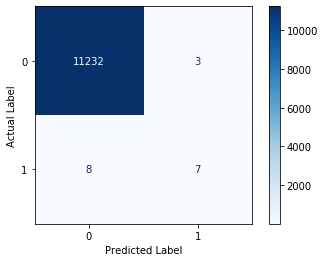

In [13]:
evaluation(Xs_test, y_test, preds, lr)

**Our model predicted that 8 fraudulent transactions were not fraud and predicted 7 cases were fraud when they were not fraudulent. **

# Class Imbalance Techniques

Our goal is to improve the recall on our test set

**Recall** :Of all the transactions that were fraudulants, how many of those did we correctly predict?
        - TP/(TP + FN)

<a id="undersample"></a>
# Imbalance Technique 1: Undersample More Frequent Class

**Undersampling**:
   - This is a technique for resampling an imbalanced dataset to omit samples from the majority class. 
   - We are reducing the representation of the majority class  
   - Big downside here is we have to discard data

**When is it reasonable to use this?**:
   - When you have a lot of data to work with
   - Your minority class isn't so small that reducing the majority class to match it would result in a drastic decrease in overall data.

In [14]:
def print_sampling_stats(Xs_train, X_train_sampled,
                         y_train, y_train_sampled,
                         y_test):
    
    print('Original dataset classes: {}'.format(Counter(y_train)))
    print('Resampled dataset classes: {}'.format(Counter(y_train_sampled)))
    print()
    print('Test dataset classes still the same to model real world: {}'.format(Counter(y_test)))

    print()
    print('X_train shape (under/reg): ', X_train_sampled.shape, Xs_train.shape)
    print('y_train shape (under/reg): ', y_train_sampled.shape, y_train.shape)
    print('X_test, shape y_test: ', Xs_test.shape, y_test.shape)

### Random UnderSampler:

In [15]:
nm = RandomUnderSampler()

X_train_under, y_train_under = nm.fit_resample(Xs_train, y_train)

print_sampling_stats(Xs_train, X_train_under,
                    y_train, y_train_under,
                    y_test)

Original dataset classes: Counter({0: 33704, 1: 46})
Resampled dataset classes: Counter({0: 46, 1: 46})

Test dataset classes still the same to model real world: Counter({0: 11235, 1: 15})

X_train shape (under/reg):  (92, 30) (33750, 30)
y_train shape (under/reg):  (92,) (33750,)
X_test, shape y_test:  (11250, 30) (11250,)


In [16]:
lr_under = LogisticRegression()
lr_under.fit(X_train_under, y_train_under)

LogisticRegression()

 Recall: 0.8666666666666667


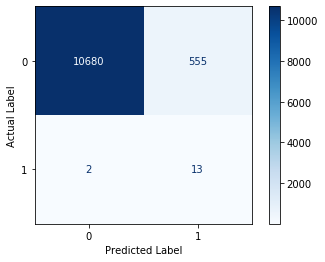

In [17]:
preds_under = lr_under.predict(Xs_test)

evaluation(Xs_test, y_test, preds_under, lr_under)

<a id="oversample"></a>
# Imbalance Technique 2: Oversample Less Frequent Class

Chooses new samples of the minority class at random with replacement.

**RandomOverSampler**:
- Oversample the minority class(es) by randomly picking samples with or without replacement.
- `replacement` can be set to True or False. It is False by default
- can change `sampling_strategy` here too

#### Instantiate and Fit RandomOverSampler

In [18]:
ros = RandomOverSampler()

X_train_over, y_train_over = ros.fit_resample(Xs_train, y_train)

print_sampling_stats(Xs_train, X_train_over,
                     y_train, y_train_over,
                     y_test)

Original dataset classes: Counter({0: 33704, 1: 46})
Resampled dataset classes: Counter({0: 33704, 1: 33704})

Test dataset classes still the same to model real world: Counter({0: 11235, 1: 15})

X_train shape (under/reg):  (67408, 30) (33750, 30)
y_train shape (under/reg):  (67408,) (33750,)
X_test, shape y_test:  (11250, 30) (11250,)


#### Fit and score Logistic Regression

In [20]:
lr_over = LogisticRegression(max_iter = 1000)

lr_over.fit(X_train_over, y_train_over)

LogisticRegression(max_iter=1000)

#### Preds & Evaluate

In [21]:
preds_ov = lr_over.predict(Xs_test)

 Recall: 0.8


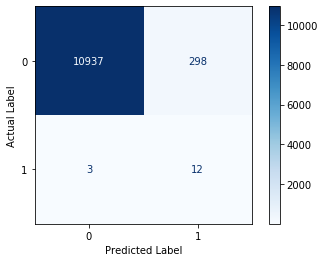

In [22]:
evaluation(Xs_test, y_test, preds_ov, lr_over)

<img src="https://media1.tenor.com/images/a7aa51ccddca1296a7f31a63cfb60f1a/tenor.gif?itemid=12704544" style="float: center; margin: 10px; height: 200px">

***Here we have 3 false negatives, and our False Positives has decreased significantly***

<a id="smote"></a>
# Imbalance Technique 3: SMOTE (Synthetic Minority Over-sampling Technique)

This technique does not just randomly oversample with replacement. Instead, it uses nearest neighbors to synthetically create fake datapoints to use for oversampling.

**SMOTE Hyperparameters**:

- `sampling_strategy`: minority/majority ratio
- `k_neighbors`: similar to KNN - specifying the number of nearest neighbors to used to construct synthetic samples. Default is 5.

#### Instantiate and fit SMOTE

In [23]:
smo = SMOTE()

X_train_smote, y_train_smote = smo.fit_resample(Xs_train, y_train)

print_sampling_stats(Xs_train, X_train_smote,
                     y_train, y_train_smote,
                     y_test)

Original dataset classes: Counter({0: 33704, 1: 46})
Resampled dataset classes: Counter({0: 33704, 1: 33704})

Test dataset classes still the same to model real world: Counter({0: 11235, 1: 15})

X_train shape (under/reg):  (67408, 30) (33750, 30)
y_train shape (under/reg):  (67408,) (33750,)
X_test, shape y_test:  (11250, 30) (11250,)


#### Fit & Score Logistic Regression

In [25]:
lr_smote = LogisticRegression(max_iter = 1000)

lr_smote.fit(X_train_smote, y_train_smote)

LogisticRegression(max_iter=1000)

#### Get Predictions and Evaluate

In [26]:
preds_smote = lr_smote.predict(Xs_test)

 Recall: 0.8


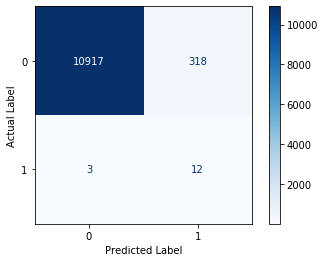

In [27]:
evaluation(Xs_test, y_test, preds_smote, lr_smote)

### Let's put this in a pipeline and use RandomizedSearch!

We need to use the imblearn Pipeline because we don't want to resample the testing data, just the training data - this pipeline will take care of that for you.

In [28]:
imb_pipe = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', SMOTE()),
        ('lr', LogisticRegression(max_iter = 10000))
    ])

In [29]:
pipe_params = {
    'sampling__sampling_strategy': ['auto', 0.75],
    'sampling__k_neighbors': [3, 5],
    'lr__C': [0.001, 0.01],
    'lr__class_weight': ['balanced', 'auto']
}

In [32]:
rs = RandomizedSearchCV(imb_pipe, pipe_params, scoring = 'recall', cv = 5)

In [33]:
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scale', StandardScaler()),
                                             ('sampling', SMOTE()),
                                             ('lr',
                                              LogisticRegression(max_iter=10000))]),
                   param_distributions={'lr__C': [0.001, 0.01],
                                        'lr__class_weight': ['balanced',
                                                             'auto'],
                                        'sampling__k_neighbors': [3, 5],
                                        'sampling__sampling_strategy': ['auto',
                                                                        0.75]},
                   scoring='recall')

In [34]:
rs.best_params_

{'sampling__sampling_strategy': 0.75,
 'sampling__k_neighbors': 5,
 'lr__class_weight': 'balanced',
 'lr__C': 0.001}

In [36]:
preds_rs = rs.predict(X_test)

 Recall: 0.8666666666666667


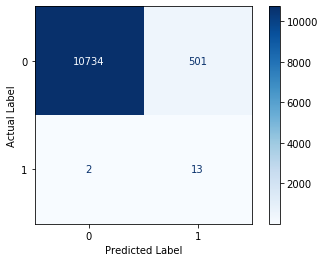

In [37]:
evaluation(Xs_test, y_test, preds_rs, rs)

<a id="weight"></a>
# Imbalance Technique 4: Weight each class in the model

Many models (including Random Forests and Logistic Regression, etc) allow you to weight each class. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data.

In [38]:
lr_balanced = LogisticRegression(class_weight = 'balanced', max_iter = 1000)

lr_balanced.fit(Xs_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

#### Get Predictions & Evaluate

 Recall: 0.8666666666666667


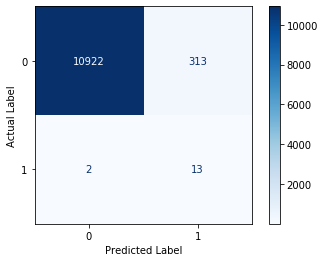

In [39]:
predz = lr_balanced.predict(Xs_test)

evaluation(Xs_test, y_test, predz, lr_balanced)